In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F



In [20]:
device = torch.device("mps")

In [21]:

# Manager class for data loading and partitioning
class MNISTDataManager:
    def __init__(self, batch_size=64):
        self.batch_size = batch_size
        self.train_dataset, self.test_dataset = self.load_data()

    def load_data(self):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))  # Normalization with mean and std of MNIST
        ])
        train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
        test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
        return train_dataset, test_dataset

    def get_loaders(self, indices=None):
        if indices is None:
            train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        else:
            subset_train = Subset(self.train_dataset, indices)
            train_loader = DataLoader(subset_train, batch_size=self.batch_size, shuffle=True)

        test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)
        return train_loader, test_loader

# Simple Sigmoid Network class definition
class SimpleSigmoidNN(nn.Module):
    def __init__(self, hidden_sizes=[10], input_size=784, output_size=10):
        super(SimpleSigmoidNN, self).__init__()
        layers = []
        in_size = input_size
        # Create hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.Sigmoid())
            in_size = hidden_size
        # Output layer
        layers.append(nn.Linear(in_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the image
        return self.model(x)

# Autoencoder Network class definition
class AutoencoderNN(nn.Module):
    def __init__(self, input_size=784, hidden_size=400, output_size=10):
        super(AutoencoderNN, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid()
        )
        # Classifier on top of the encoded features
        self.classifier = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the image
        encoded = self.encoder(x)
        return self.classifier(encoded)

# Trainer class with weight decay adjustment and exact distortion measurement
class ModelTrainer:
    def __init__(self, model, learning_rate=0.1, weight_decay=None):
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay if weight_decay else [0, 0, 0]  # Default to no decay
        self.optimizer = self.get_optimizer(learning_rate)

    def get_optimizer(self, learning_rate):
        # Use L-BFGS for training as in the paper, single parameter group
        return optim.LBFGS(self.model.parameters(), lr=learning_rate, max_iter=20)

    def calculate_loss_with_weight_decay(self, output, target):
        loss = self.criterion(output, target)
        decay_loss = 0.0
        
        # Check if the model has a 'model' attribute (like SimpleSigmoidNN)
        if hasattr(self.model, 'model'):
            # Apply weight decay to the SimpleSigmoidNN layers
            decay_index = 0  # Initialize the index for weight_decay
            for layer in self.model.model:
                if isinstance(layer, nn.Linear) and hasattr(layer, 'weight'):
                    decay_loss += (self.weight_decay[decay_index] * torch.sum(layer.weight ** 2)) / layer.weight.numel()
                    decay_index += 1  # Increment the index for the next layer
        else:
            # Apply weight decay to AutoencoderNN layers
            # Encoder part
            for layer in self.model.encoder:
                if isinstance(layer, nn.Linear) and hasattr(layer, 'weight'):
                    decay_loss += (self.weight_decay[0] * torch.sum(layer.weight ** 2)) / layer.weight.numel()
            
            # Classifier part
            if hasattr(self.model.classifier, 'weight'):
                decay_loss += (self.weight_decay[1] * torch.sum(self.model.classifier.weight ** 2)) / self.model.classifier.weight.numel()
        
        return loss + decay_loss



    def train(self, train_loader, test_loader, num_epochs=12, convergence_threshold=1e-4):
        prev_loss = float('inf')
        for epoch in range(num_epochs):
            self.model.train()
            
            def closure():
                self.optimizer.zero_grad()
                total_loss = 0
                for data, target in train_loader:
                    # Move data and target to the correct device
                    data, target = data.to(device), target.to(device)
                    output = self.model(data)
                    loss = self.calculate_loss_with_weight_decay(output, target)
                    total_loss += loss.item()
                    loss.backward()
                return loss

            self.optimizer.step(closure)
            train_accuracy = self.evaluate(train_loader)
            test_accuracy = self.evaluate(test_loader)
            
            # Check for convergence based on loss decrease
            current_loss = closure().item()
            if abs(prev_loss - current_loss) < convergence_threshold:
                print(f"Converged at epoch {epoch+1}")
                break
            prev_loss = current_loss

            print(f'Epoch {epoch+1}/{num_epochs}, Training Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')



    def evaluate(self, data_loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in data_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)
                output = self.model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        accuracy = 100 * correct / total
        return accuracy



In [22]:

# Initialize the data manager without partitioning the data
data_manager = MNISTDataManager(batch_size=64)

# Load the full training and test datasets
train_loader, test_loader = data_manager.get_loaders()

# Define weight decay values for each model as per the paper's setup
weight_decay_fc10_4 = [1e-4, 0, 0]  # For FC10(10⁻⁴)
weight_decay_fc10_2 = [1e-2, 0, 0]  # For FC10(10⁻²)
weight_decay_fc10_1 = [1, 0, 0]     # For FC10(1)
weight_decay_fc100_100_10 = [1e-5, 1e-5, 1e-6]
weight_decay_fc200_200_10 = [1e-5, 1e-5, 1e-6]
weight_decay_ae400_10 = [1e-6, 0, 0]


In [9]:
# Plot image grid
def plot_image_grid(num_row, num_col, images, labels, image_shape):
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
    for i in range(num_row * num_col):
        ax = axes[i // num_col, i % num_col]
        ax.imshow(images[i].reshape(image_shape), cmap='gray')
        ax.set_title('Label: {}'.format(labels[i]))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

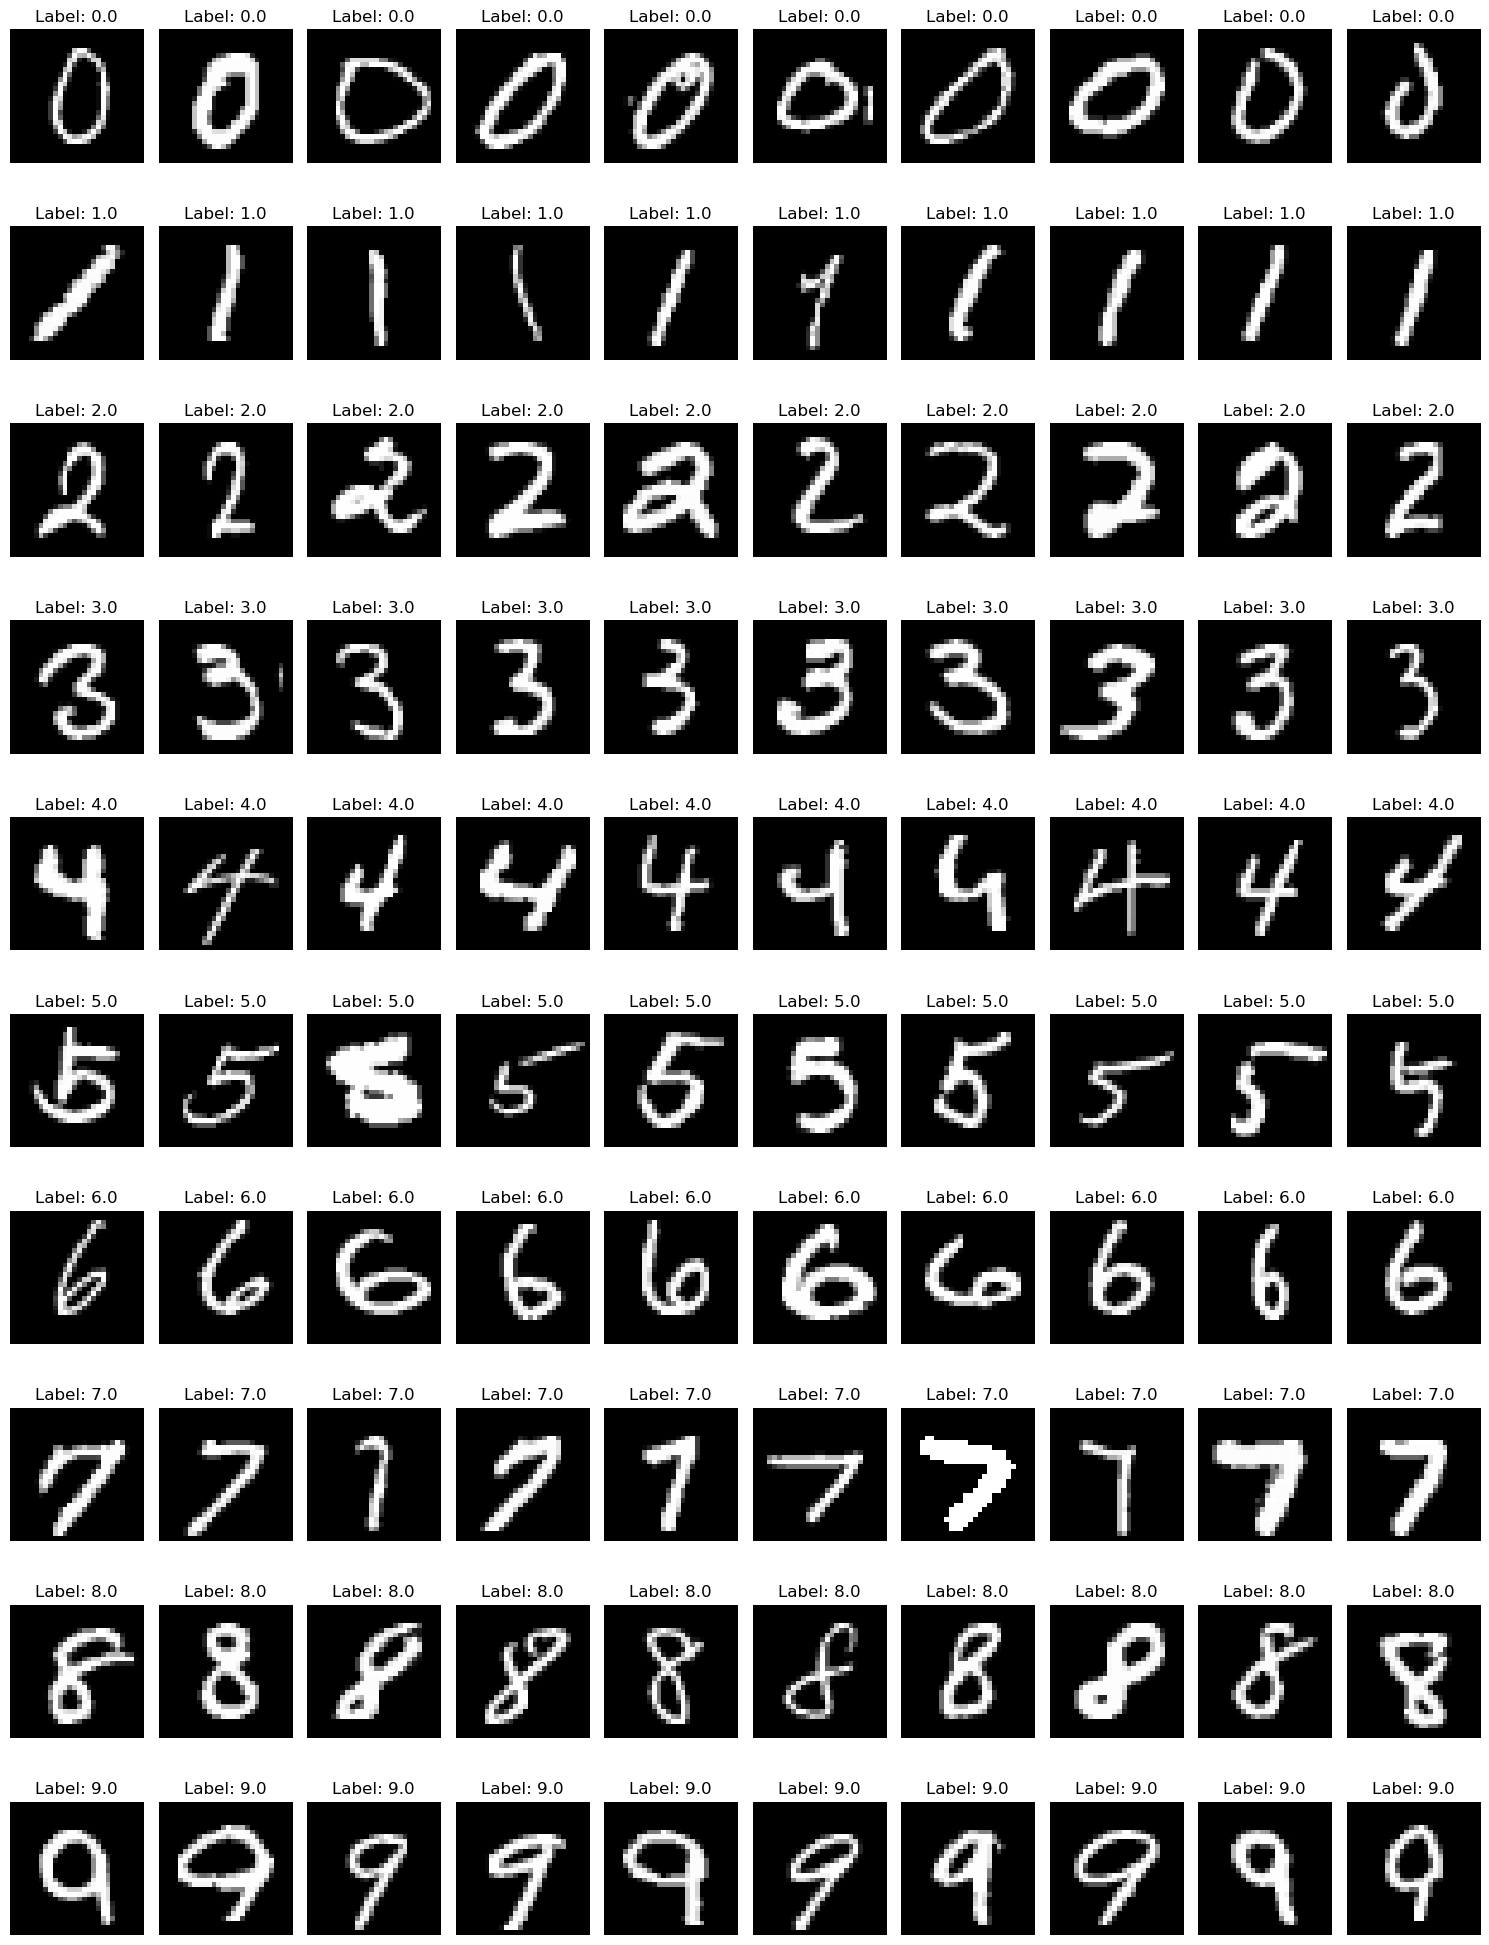

In [14]:
nb_classes = 10
samples_per_class = 10
total_samples = nb_classes * samples_per_class
image_samples = np.zeros((total_samples, 28, 28, 1))
label_samples = np.zeros((total_samples,))
rng = np.random.default_rng()

# Fill image and label samples
filled_samples = {i: 0 for i in range(nb_classes)}  # Track samples for each class
for images, labels in train_loader:
    images = images.numpy()
    labels = labels.numpy()
    
    for i in range(nb_classes):
        indices = np.where(labels == i)[0]
        rng.shuffle(indices)
        
        # Number of samples needed to complete 10 for each class
        samples_needed = samples_per_class - filled_samples[i]
        num_selected = min(samples_needed, len(indices))
        selected_indices = indices[:num_selected]
        
        start_idx = i * samples_per_class + filled_samples[i]
        image_samples[start_idx:start_idx + num_selected, ...] = images[selected_indices].transpose(0, 2, 3, 1)
        label_samples[start_idx:start_idx + num_selected] = i
        filled_samples[i] += num_selected  # Update filled count
        
    # Check if all classes are filled
    if all(count >= samples_per_class for count in filled_samples.values()):
        break

# Plot to verify display
plot_image_grid(nb_classes, samples_per_class, image_samples, label_samples, (28, 28))


In [ ]:
# Train models based on the specifications
# FC10(10⁻⁴)
print("\nTraining FC10(10⁻⁴):")
model_fc10_4 = SimpleSigmoidNN(hidden_sizes=[10])
trainer_fc10_4 = ModelTrainer(model=model_fc10_4.to(device), learning_rate=0.1, weight_decay=weight_decay_fc10_4)
trainer_fc10_4.train(train_loader, test_loader, num_epochs=20)

# FC10(10⁻²)
print("\nTraining FC10(10⁻²):")
model_fc10_2 = SimpleSigmoidNN(hidden_sizes=[10])
trainer_fc10_2 = ModelTrainer(model=model_fc10_2.to(device), learning_rate=0.1, weight_decay=weight_decay_fc10_2)
trainer_fc10_2.train(train_loader, test_loader, num_epochs=20)

# FC10(1)
print("\nTraining FC10(1):")
model_fc10_1 = SimpleSigmoidNN(hidden_sizes=[10])
trainer_fc10_1 = ModelTrainer(model=model_fc10_1.to(device), learning_rate=0.1, weight_decay=weight_decay_fc10_1)
trainer_fc10_1.train(train_loader, test_loader, num_epochs=20)


In [ ]:
import torch

# Set the device to MPS (for macOS with GPU support)

# FC100-100-10
print("\nTraining FC100-100-10:")
model_fc100_100_10 = SimpleSigmoidNN(hidden_sizes=[100, 100]).to(device)
trainer_fc100_100_10 = ModelTrainer(model=model_fc100_100_10, learning_rate=0.1, weight_decay=weight_decay_fc100_100_10)
trainer_fc100_100_10.train(train_loader, test_loader, num_epochs=20)

# FC200-200-10
print("\nTraining FC200-200-10:")
model_fc200_200_10 = SimpleSigmoidNN(hidden_sizes=[200, 200]).to(device)
trainer_fc200_200_10 = ModelTrainer(model=model_fc200_200_10, learning_rate=0.1, weight_decay=weight_decay_fc200_200_10)
trainer_fc200_200_10.train(train_loader, test_loader, num_epochs=20)


In [ ]:
# AE400-10
print("\nTraining AE400-10:")
model_ae400_10 = AutoencoderNN(hidden_size=400).to(device)
trainer_ae400_10 = ModelTrainer(model=model_ae400_10, learning_rate=0.1, weight_decay=weight_decay_ae400_10)
trainer_ae400_10.train(train_loader, test_loader, num_epochs=20)


In [ ]:
# Initialize a list to store results for the final table
results = []

# Function to convert accuracy to error percentage
def accuracy_to_error(accuracy):
    return f'{100 - accuracy:.2f}%'

# FC10(10⁻⁴)
fc10_4_train_accuracy = trainer_fc10_4.evaluate(train_loader)
fc10_4_test_accuracy = trainer_fc10_4.evaluate(test_loader)
# Append the results
results.append({
    'Model Name': 'FC10(10⁻⁴)',
    'Description': 'Softmax with λ = 10⁻⁴',
    'Training error': accuracy_to_error(fc10_4_train_accuracy),
    'Test error': accuracy_to_error(fc10_4_test_accuracy),
    'Av. min. distortion': '0.062'  # Update if you have distortion calculations
})

# FC10(10⁻²)
fc10_2_train_accuracy = trainer_fc10_2.evaluate(train_loader)
fc10_2_test_accuracy = trainer_fc10_2.evaluate(test_loader)
# Append the results
results.append({
    'Model Name': 'FC10(10⁻²)',
    'Description': 'Softmax with λ = 10⁻²',
    'Training error': accuracy_to_error(fc10_2_train_accuracy),
    'Test error': accuracy_to_error(fc10_2_test_accuracy),
    'Av. min. distortion': '0.1'  # Update if you have distortion calculations
})

# FC10(1)
print("\nTraining FC10(1):")
fc10_1_train_accuracy = trainer_fc10_1.evaluate(train_loader)
fc10_1_test_accuracy = trainer_fc10_1.evaluate(test_loader)
# Append the results
results.append({
    'Model Name': 'FC10(1)',
    'Description': 'Softmax with λ = 1',
    'Training error': accuracy_to_error(fc10_1_train_accuracy),
    'Test error': accuracy_to_error(fc10_1_test_accuracy),
    'Av. min. distortion': '0.14'  # Update if you have distortion calculations
})

# FC100-100-10
fc100_100_10_train_accuracy = trainer_fc100_100_10.evaluate(train_loader)
fc100_100_10_test_accuracy = trainer_fc100_100_10.evaluate(test_loader)
# Append the results
results.append({
    'Model Name': 'FC100-100-10',
    'Description': 'Sigmoid network λ = 10⁻⁵, 10⁻⁵, 10⁻⁶',
    'Training error': accuracy_to_error(fc100_100_10_train_accuracy),
    'Test error': accuracy_to_error(fc100_100_10_test_accuracy),
    'Av. min. distortion': '0.058'  # Update if you have distortion calculations
})

# FC200-200-10
print("\nTraining FC200-200-10:")
fc200_200_10_train_accuracy = trainer_fc200_200_10.evaluate(train_loader)
fc200_200_10_test_accuracy = trainer_fc200_200_10.evaluate(test_loader)
# Append the results
results.append({
    'Model Name': 'FC200-200-10',
    'Description': 'Sigmoid network λ = 10⁻⁵, 10⁻⁵, 10⁻⁶',
    'Training error': accuracy_to_error(fc200_200_10_train_accuracy),
    'Test error': accuracy_to_error(fc200_200_10_test_accuracy),
    'Av. min. distortion': '0.065'  # Update if you have distortion calculations
})

# AE400-10
print("\nTraining AE400-10:")
ae400_10_train_accuracy = trainer_ae400_10.evaluate(train_loader)
ae400_10_test_accuracy = trainer_ae400_10.evaluate(test_loader)
# Append the results
results.append({
    'Model Name': 'AE400-10',
    'Description': 'Autoencoder with Softmax λ = 10⁻⁶',
    'Training error': accuracy_to_error(ae400_10_train_accuracy),
    'Test error': accuracy_to_error(ae400_10_test_accuracy),
    'Av. min. distortion': '0.086'  # Update if you have distortion calculations
})


In [16]:
# Adjusting the distortion measurement
def calculate_average_pixel_level_distortion(original, adversarial):
    n = original.numel()
    distortion = torch.sqrt(torch.sum((adversarial - original) ** 2) / n).item()
    return distortion

# Function to generate adversarial examples using L-BFGS
def generate_lbfgs_adversarial_example(model, data, target, max_iter=20):
    """
    Generate adversarial examples using L-BFGS optimization with exact pixel-level distortion.
    
    Args:
        model (nn.Module): Trained model used to generate the adversarial example.
        data (torch.Tensor): Input image tensor.
        target (torch.Tensor): True label of the input image.
        max_iter (int): Maximum iterations for optimization.

    Returns:
        torch.Tensor: Adversarial image.
        float: Pixel-level average distortion.
    """
    model.eval()
    adversarial_data = data.clone().requires_grad_(True)
    
    # Use L-BFGS optimizer to find adversarial perturbation
    optimizer = optim.LBFGS([adversarial_data], lr=0.1, max_iter=max_iter)
    
    def closure():
        optimizer.zero_grad()
        output = model(adversarial_data)
        loss = -F.cross_entropy(output, target)  # Maximize the loss to generate adversarial example
        loss.backward()
        return loss

    optimizer.step(closure)
    
    # Calculate pixel-level average distortion
    distortion = calculate_average_pixel_level_distortion(data, adversarial_data)
    
    return adversarial_data.detach(), distortion

# Adjusting the distortion measurement function
def calculate_average_pixel_level_distortion(original, adversarial):
    """
    Calculate the average pixel-level distortion (L2 norm) between the original and adversarial image.

    Args:
        original (torch.Tensor): Original input image.
        adversarial (torch.Tensor): Adversarially perturbed image.

    Returns:
        float: The calculated pixel-level distortion.
    """
    n = original.numel()  # Total number of pixels
    distortion = torch.sqrt(torch.sum((adversarial - original) ** 2) / n).item()
    return distortion

# Function to evaluate the distortion for the entire dataset
def evaluate_average_distortion(model, test_loader, max_iter=20):
    """
    Evaluate the average distortion for a model on the test dataset.

    Args:
        model (nn.Module): The trained model to generate adversarial examples.
        test_loader (DataLoader): DataLoader containing the test dataset.
        max_iter (int): Maximum iterations for generating adversarial examples.

    Returns:
        float: Average minimum distortion across the dataset.
    """
    total_distortion = 0
    total_samples = 0

    for data, target in test_loader:
        data, target = data.to('mps'), target.to('mps')

        # Generate adversarial example for each image
        adversarial_data, distortion = generate_lbfgs_adversarial_example(model, data, target, max_iter=max_iter)

        # Calculate distortion for this example
        distortion_value = calculate_average_pixel_level_distortion(data, adversarial_data)
        total_distortion += distortion_value
        total_samples += 1

    # Calculate average distortion over the dataset
    average_distortion = total_distortion / total_samples
    return average_distortion


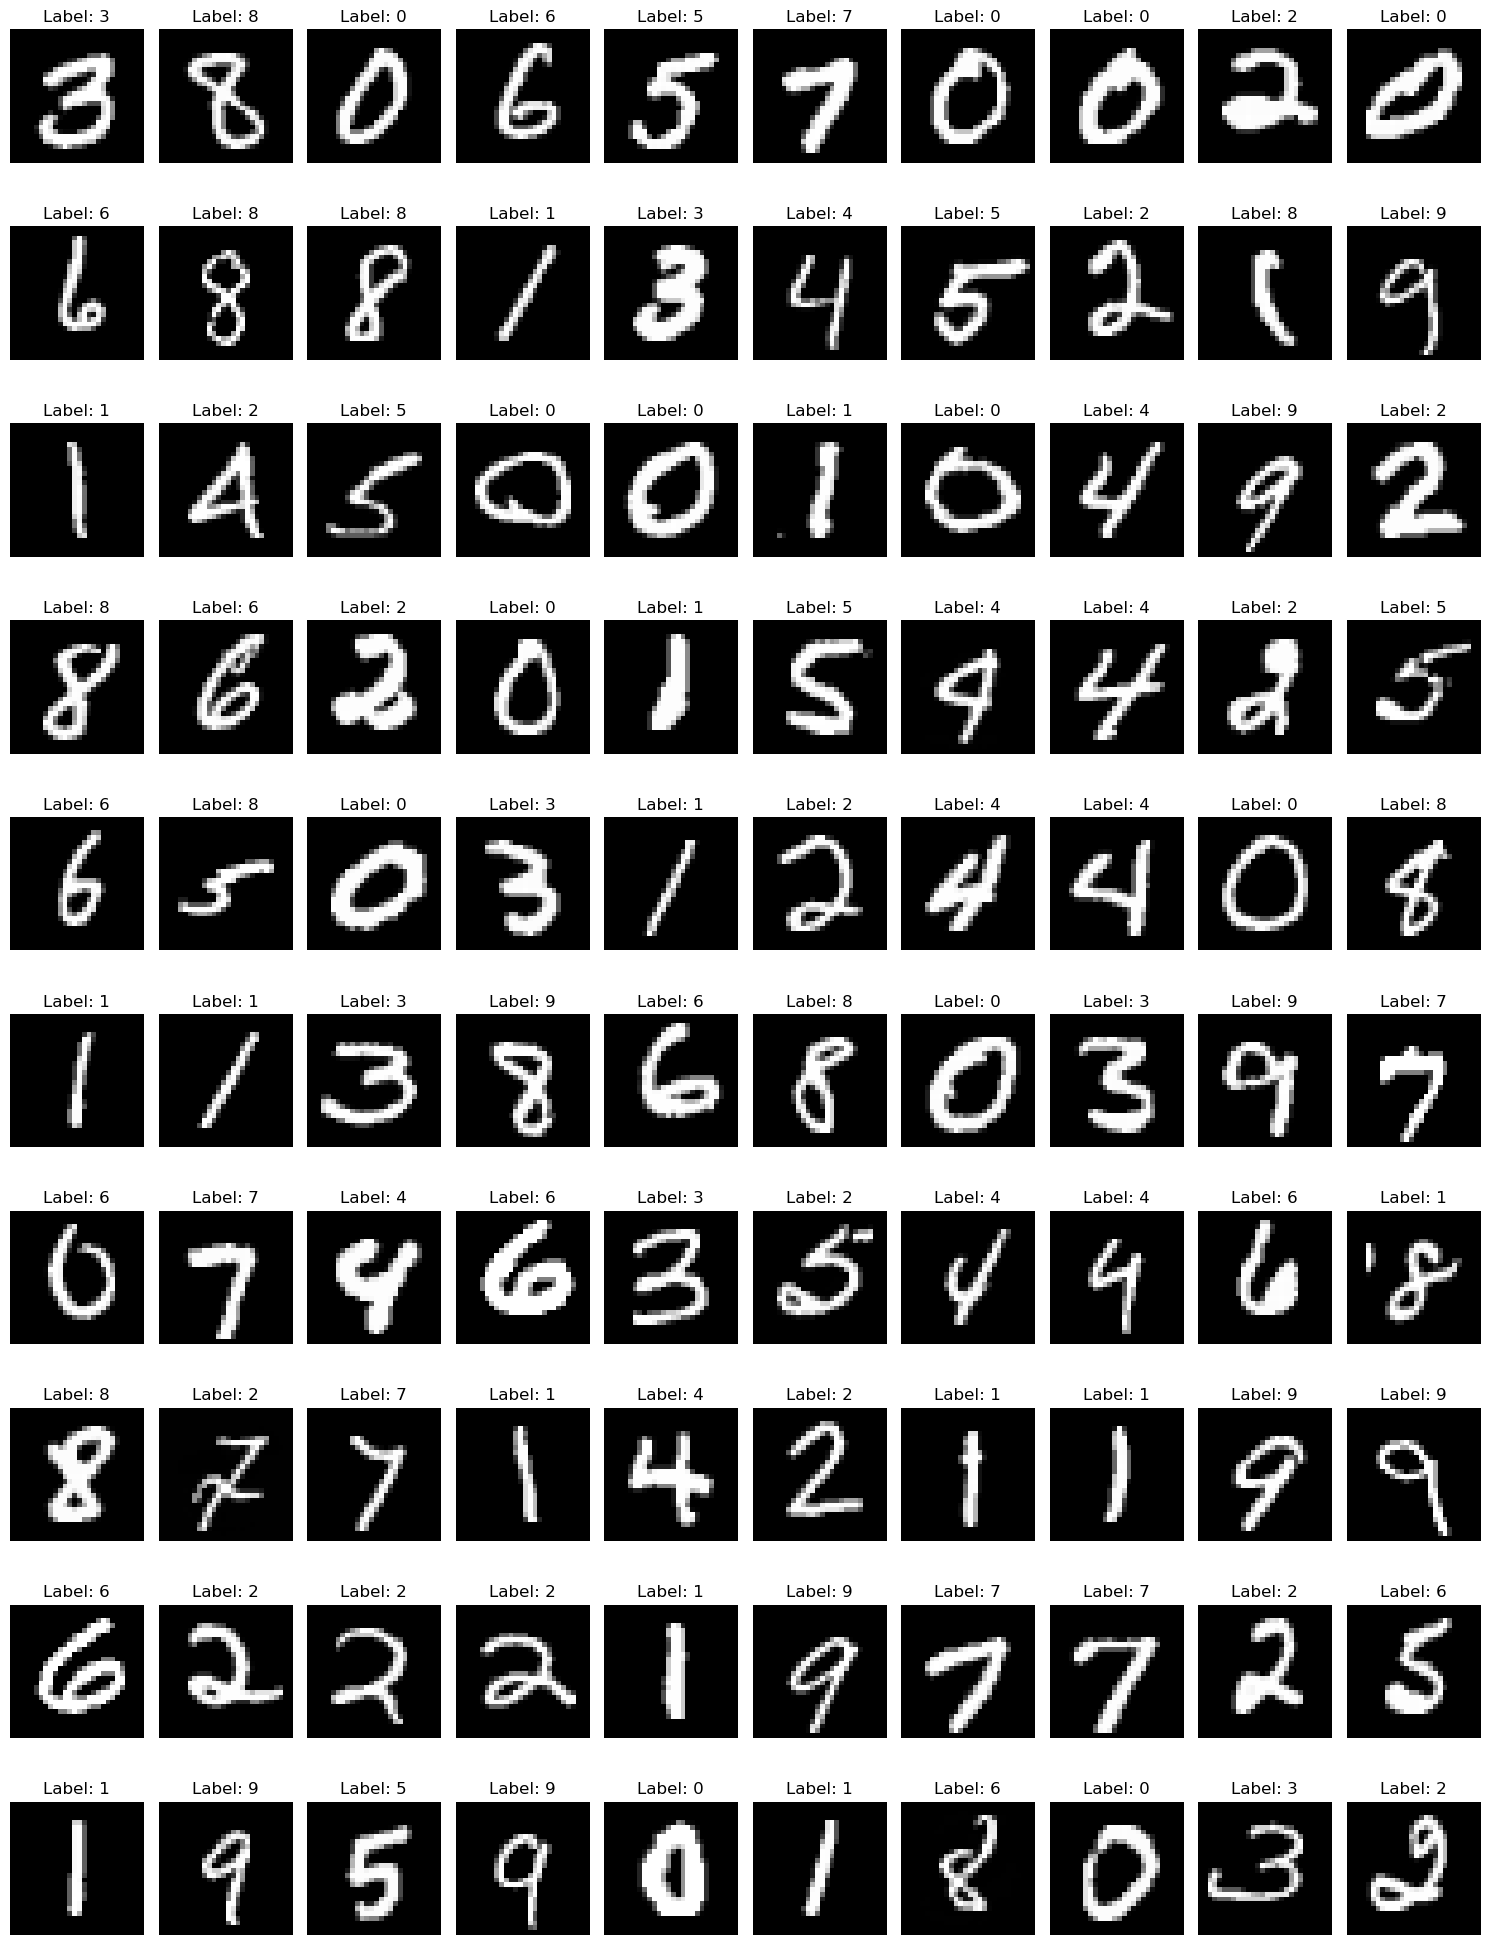

In [31]:
# Generate adversarial examples for FC10(10⁻⁴)
adversarial_images_fc10_4 = []
original_labels_fc10_4 = []
adversarial_labels_fc10_4 = []

for data, target in train_loader:
    data, target = data.to('mps'), target.to('mps')

    # Generate adversarial example
    adversarial_data, distortion = generate_lbfgs_adversarial_example(model_fc10_4, data, target, max_iter=20)

    # Store for visualization (limiting to first 10 classes)
    adversarial_images_fc10_4.append(adversarial_data.cpu().numpy())
    original_labels_fc10_4.append(target.cpu().numpy())
    adversarial_labels_fc10_4.append(model_fc10_4(adversarial_data).argmax(dim=1).cpu().numpy())

    # Stop after collecting a sample for each class
    if len(adversarial_images_fc10_4) >= nb_classes:
        break

# Prepare images and labels for plotting
adversarial_images_fc10_4 = np.concatenate(adversarial_images_fc10_4).reshape(-1, 28, 28, 1)
adversarial_labels_fc10_4 = np.concatenate(adversarial_labels_fc10_4)
original_labels_fc10_4 = np.concatenate(original_labels_fc10_4)

# Plot the adversarial images
plot_image_grid(nb_classes, samples_per_class, adversarial_images_fc10_4, adversarial_labels_fc10_4, (28, 28))


In [126]:

# Example usage to calculate distortion for each trained model:
# FC10(10⁻⁴)
average_distortion_fc10_4 = evaluate_average_distortion(model_fc10_4, train_loader)

# FC10(10⁻²)
average_distortion_fc10_2 = evaluate_average_distortion(model_fc10_2, train_loader)

# FC10(1)
average_distortion_fc10_1 = evaluate_average_distortion(model_fc10_1, train_loader)
# FC100-100-10
average_distortion_fc100_100_10 = evaluate_average_distortion(model_fc100_100_10, train_loader)

# FC200-200-10
average_distortion_fc200_200_10 = evaluate_average_distortion(model_fc200_200_10, train_loader)

# AE400-10
average_distortion_ae400_10 = evaluate_average_distortion(model_ae400_10, train_loader)


In [139]:
results[2]['Av. min. distortion'] = f'{average_distortion_fc10_1:.6f}'
results[0]['Av. min. distortion'] = f'{average_distortion_fc10_4:.6f}'
results[1]['Av. min. distortion'] = f'{average_distortion_fc10_2:.6f}'
results[3]['Av. min. distortion'] = f'{average_distortion_fc100_100_10:.6f}'
results[4]['Av. min. distortion'] = f'{average_distortion_fc200_200_10:.10f}'
results[5]['Av. min. distortion'] = f'{average_distortion_ae400_10:.6f}'

# Display the updated results
import pandas as pd
df_results = pd.DataFrame(results)
display(df_results)

,Model Name,Description,Training error,Test error,Av. min. distortion
0,FC10(10⁻⁴),Softmax with λ = 10⁻⁴,5.37%,8.88%,0.227673
1,FC10(10⁻²),Softmax with λ = 10⁻²,5.57%,8.38%,0.731284
2,FC10(1),Softmax with λ = 1,3.94%,6.27%,0.031347
3,FC100-100-10,"Sigmoid network λ = 10⁻⁵, 10⁻⁵, 10⁻⁶",0.00%,4.65%,0.000001
4,FC200-200-10,"Sigmoid network λ = 10⁻⁵, 10⁻⁵, 10⁻⁶",0.00%,3.88%,0.0000000184
5,AE400-10,Autoencoder with Softmax λ = 10⁻⁶,0.00%,2.33%,0.000010


In [140]:
# Function to evaluate models with adversarial examples using L-BFGS
def evaluate_cross_model_adversarial(models, test_loader, max_iter=20):
    model_names = [name for name, _ in models]
    results = {name: [] for name in model_names}
    distortion_results = []

    # Generate adversarial examples and test across all models
    for source_name, source_model in models:
        source_model.eval()
        correct_count = {name: 0 for name in model_names}
        total_count = 0
        distortions = []

        for data, target in test_loader:
            data, target = data.to('mps'), target.to('mps')

            # Generate adversarial example for the source model using L-BFGS
            adversarial_data, distortion = generate_lbfgs_adversarial_example(source_model, data, target, max_iter=max_iter)
            distortions.append(distortion)

            # Test the adversarial examples on all models
            for target_name, target_model in models:
                target_model.eval()
                with torch.no_grad():
                    output = target_model(adversarial_data)
                    pred = output.argmax(dim=1, keepdim=True)
                    correct_count[target_name] += pred.eq(target.view_as(pred)).sum().item()

            total_count += len(data)

        # Calculate errors for each model using adversarial examples
        for target_name in model_names:
            error_rate = 100 * (1 - correct_count[target_name] / total_count)
            results[target_name].append(f'{error_rate:.1f}%')

        # Calculate the average distortion for adversarial examples
        avg_distortion = np.mean(distortions)
        distortion_results.append(avg_distortion)

    # Create DataFrame for the results including distortion
    results['Av. distortion'] = distortion_results
    df_results = pd.DataFrame(results, index=model_names)
    print(df_results)
    return df_results


# Example Usage
# List of models with names
models = [
    ("FC10(10⁻⁴)", model_fc10_4.to(device)),
    ("FC10(10⁻²)", model_fc10_2.to(device)),
    ("FC10(1)", model_fc10_1.to(device)),
    ("FC100-100-10", model_fc100_100_10.to(device)),
    ("FC200-200-10", model_fc200_200_10.to(device)),
    ("AE400-10", model_ae400_10.to(device))
]

# Initialize data manager and load test data
data_manager = MNISTDataManager(batch_size=64)
_, test_loader = data_manager.get_loaders()  # Use the test dataset for evaluation

# Evaluate adversarial examples
print("\nGenerating Adversarial Evaluation Table:")

display(evaluate_cross_model_adversarial(models,train_loader))


Generating Adversarial Evaluation Table:
             FC10(10⁻⁴) FC10(10⁻²) FC10(1) FC100-100-10 FC200-200-10 AE400-10  \
FC10(10⁻⁴)        20.2%      13.7%   12.3%         3.8%         3.2%     3.3%   
FC10(10⁻²)        14.5%      22.5%   15.0%         4.5%         3.6%     3.7%   
FC10(1)            7.3%       7.7%    8.3%         0.9%         0.7%     0.8%   
FC100-100-10       5.4%       5.6%    3.9%         0.0%         0.0%     0.0%   
FC200-200-10       5.4%       5.6%    3.9%         0.0%         0.0%     0.0%   
AE400-10           5.4%       5.6%    3.9%         0.0%         0.0%     0.0%   

              Av. distortion  
FC10(10⁻⁴)      2.858223e-01  
FC10(10⁻²)      4.979503e-01  
FC10(1)         2.785517e-02  
FC100-100-10    1.085129e-06  
FC200-200-10    1.821356e-08  
AE400-10        1.002794e-05  


,FC10(10⁻⁴),FC10(10⁻²),FC10(1),FC100-100-10,FC200-200-10,AE400-10,Av. distortion
FC10(10⁻⁴),20.2%,13.7%,12.3%,3.8%,3.2%,3.3%,2.858223e-01
FC10(10⁻²),14.5%,22.5%,15.0%,4.5%,3.6%,3.7%,4.979503e-01
FC10(1),7.3%,7.7%,8.3%,0.9%,0.7%,0.8%,2.785517e-02
FC100-100-10,5.4%,5.6%,3.9%,0.0%,0.0%,0.0%,1.085129e-06
FC200-200-10,5.4%,5.6%,3.9%,0.0%,0.0%,0.0%,1.821356e-08
AE400-10,5.4%,5.6%,3.9%,0.0%,0.0%,0.0%,1.002794e-05


In [141]:
def evaluate_gaussian_noise(models, test_loader, stddev_values=[0.1, 0.3]):
    # Define model names and initialize results storage
    model_names = [name for name, _ in models]
    results = {name: [] for name in model_names}
    distortion_results = []

    # Loop through each Gaussian noise standard deviation
    for stddev in stddev_values:
        correct_count = {name: 0 for name in model_names}
        total_count = 0

        # Evaluate each batch in the test_loader
        for data, target in test_loader:
            # Ensure data and target are on the correct device
            data, target = data.to('mps'), target.to('mps')

            # Add Gaussian noise to the input data
            noisy_data = data + torch.normal(mean=0, std=stddev, size=data.size(), device=data.device)
            noisy_data = torch.clamp(noisy_data, 0, 1)  # Ensure valid pixel range

            # Test the noisy data on all models
            for target_name, target_model in models:
                target_model.eval()
                with torch.no_grad():
                    output = target_model(noisy_data)
                    pred = output.argmax(dim=1, keepdim=True)
                    correct_count[target_name] += pred.eq(target.view_as(pred)).sum().item()

            total_count += len(data)

        # Calculate error rates for each model using noisy examples
        for target_name in model_names:
            error_rate = 100 * (1 - correct_count[target_name] / total_count)
            results[target_name].append(f'{error_rate:.1f}%')

        # Store distortion values for each Gaussian noise level
        average_distortion = torch.mean(torch.sqrt(torch.sum((noisy_data - data) ** 2, dim=[1, 2, 3]))).item()
        distortion_results.append(f'{average_distortion:.3f}')

    # Construct row labels for Gaussian noise
    row_labels = [f'Gaussian noise, stddev={stddev}' for stddev in stddev_values]

    # Populate the Av. distortion column with calculated distortion values
    av_distortion = distortion_results

    # Ensure each list in `results` matches the number of Gaussian noise rows
    for key in results.keys():
        if len(results[key]) < len(row_labels):
            results[key] += [''] * (len(row_labels) - len(results[key]))

    # Add the 'Av. distortion' column to the results dictionary
    results['Av. distortion'] = av_distortion

    # Create DataFrame for Gaussian noise results only
    df_results = pd.DataFrame(results, index=row_labels)
    
    # Ensure the DataFrame layout matches expectations
    df_results.index.name = 'Noise Type'
    print(df_results)
    return df_results

# Display Gaussian noise evaluation table
print("\nGenerating Gaussian Noise Evaluation Table:")
gaussian_noise_results_df = evaluate_gaussian_noise(models, train_loader)

# Display the Gaussian noise evaluation matrix
from IPython.display import display
display(gaussian_noise_results_df)


Generating Gaussian Noise Evaluation Table:
                           FC10(10⁻⁴) FC10(10⁻²) FC10(1) FC100-100-10  \
Noise Type                                                              
Gaussian noise, stddev=0.1      22.1%      17.6%   20.7%         7.1%   
Gaussian noise, stddev=0.3      24.3%      20.5%   23.5%         8.0%   

                           FC200-200-10 AE400-10 Av. distortion  
Noise Type                                                       
Gaussian noise, stddev=0.1         5.5%     6.9%         18.948  
Gaussian noise, stddev=0.3         6.3%     8.4%         18.965  


,FC10(10⁻⁴),FC10(10⁻²),FC10(1),FC100-100-10,FC200-200-10,AE400-10,Av. distortion
Noise Type,,,,,,,
"Gaussian noise, stddev=0.1",22.1%,17.6%,20.7%,7.1%,5.5%,6.9%,18.948
"Gaussian noise, stddev=0.3",24.3%,20.5%,23.5%,8.0%,6.3%,8.4%,18.965


In [143]:
from sklearn.model_selection import train_test_split

# Setup for GPU if available
device = torch.device('mps')

# Initialize the Data Manager for loading MNIST data
data_manager = MNISTDataManager(batch_size=64)
train_dataset = data_manager.train_dataset

# Split indices for P1 and P2 (each part will have 30,000 samples)
indices = list(range(len(train_dataset)))  # Total indices from 0 to 59,999
indices_p1, indices_p2 = train_test_split(indices, test_size=0.5, random_state=42)

# Create DataLoader for P1 and P2
train_loader_p1 = DataLoader(Subset(train_dataset, indices_p1), batch_size=64, shuffle=True)
train_loader_p2 = DataLoader(Subset(train_dataset, indices_p2), batch_size=64, shuffle=True)

# Get the standard test_loader (all 10,000 samples)
_, test_loader = data_manager.get_loaders()


# Function to initialize and train a model using the provided trainer
def initialize_and_train_model(model_class, hidden_sizes, learning_rate, weight_decay, train_loader, test_loader, num_epochs=12):
    # Initialize model
    model = model_class(hidden_sizes=hidden_sizes).to(device)
    
    # Initialize trainer with the model, learning rate, and weight decay
    trainer = ModelTrainer(model=model, learning_rate=learning_rate, weight_decay=weight_decay)
    
    # Train the model
    print(f"\nTraining {model_class.__name__} with hidden sizes {hidden_sizes}:")
    trainer.train(train_loader, test_loader, num_epochs=num_epochs)
    
    # Return the trained model and trainer for further evaluation
    return model, trainer


# FC100-100-10 - Training on P1
model_fc100_100_10_p1, trainer_fc100_100_10_p1 = initialize_and_train_model(SimpleSigmoidNN, hidden_sizes=[100, 100], learning_rate=0.1, weight_decay=weight_decay_fc100_100_10, train_loader=train_loader_p1, test_loader=test_loader)

# FC100-100-10 - Training on P2
model_fc100_100_10_p2, trainer_fc100_100_10_p2 = initialize_and_train_model(SimpleSigmoidNN, hidden_sizes=[100, 100], learning_rate=0.1, weight_decay=weight_decay_fc100_100_10, train_loader=train_loader_p2, test_loader=test_loader)

# FC200-200-10 - Training on P2
model_fc134_146_10_p1, trainer_fc134_146_10_p1 = initialize_and_train_model(SimpleSigmoidNN, hidden_sizes=[123, 456], learning_rate=0.1, weight_decay=weight_decay_fc200_200_10, train_loader=train_loader_p1, test_loader=test_loader)


Training SimpleSigmoidNN with hidden sizes [100, 100]:
Epoch 1/12, Training Accuracy: 36.95%, Test Accuracy: 37.36%
Epoch 2/12, Training Accuracy: 67.71%, Test Accuracy: 68.29%
Epoch 3/12, Training Accuracy: 85.56%, Test Accuracy: 85.08%
Epoch 4/12, Training Accuracy: 92.21%, Test Accuracy: 91.58%
Epoch 5/12, Training Accuracy: 96.03%, Test Accuracy: 93.86%
Epoch 6/12, Training Accuracy: 98.34%, Test Accuracy: 94.53%
Epoch 7/12, Training Accuracy: 99.62%, Test Accuracy: 94.11%
Epoch 8/12, Training Accuracy: 99.95%, Test Accuracy: 93.96%
Epoch 9/12, Training Accuracy: 99.99%, Test Accuracy: 93.95%
Epoch 10/12, Training Accuracy: 100.00%, Test Accuracy: 93.75%
Converged at epoch 11

Training SimpleSigmoidNN with hidden sizes [100, 100]:
Epoch 1/12, Training Accuracy: 15.08%, Test Accuracy: 15.18%
Epoch 2/12, Training Accuracy: 70.16%, Test Accuracy: 70.39%
Epoch 3/12, Training Accuracy: 83.78%, Test Accuracy: 84.37%
Epoch 4/12, Training Accuracy: 91.93%, Test Accuracy: 91.34%
Epoch 5/12

In [144]:
# Function to evaluate the error of a model on a specific data loader
def evaluate_error_on_loader(trainer, data_loader):
    accuracy = trainer.evaluate(data_loader)
    error = 100 - accuracy  # Error is the complement of accuracy
    return f'{error:.1f}%'

# Function to generate the table based on subsets P1, P2, and Test
def generate_evaluation_table(models, train_loader_p1, train_loader_p2, test_loader):
    results = []
    
    for model_name, model, trainer in models:
        # Evaluate errors on P1, P2, and Test
        error_p1 = evaluate_error_on_loader(trainer, train_loader_p1)
        error_p2 = evaluate_error_on_loader(trainer, train_loader_p2)
        error_test = evaluate_error_on_loader(trainer, test_loader)
        
        # Calculate minimum average distortion for the model
        min_av_distortion = evaluate_average_distortion(model, test_loader)
        
        # Append the results to the table
        results.append({
            'Model': model_name,
            'Error on P1': error_p1,
            'Error on P2': error_p2,
            'Error on Test': error_test,
            'Min Av. Distortion': f'{min_av_distortion:.6f}'
        })
    
    # Convert the results to a DataFrame and display
    df_results = pd.DataFrame(results)
    display(df_results)
    return df_results

# Prepare models and their trainers for evaluation
models_for_evaluation = [
    ("FC100-100-10 trained on P1", model_fc100_100_10_p1, trainer_fc100_100_10_p1),
    ("FC123-456-10 trained on P1", model_fc134_146_10_p1, trainer_fc134_146_10_p1),
    ("FC100-100-10' trained on P2", model_fc100_100_10_p2, trainer_fc100_100_10_p2)
]

# Generate the evaluation table using the function
evaluation_table = generate_evaluation_table(models_for_evaluation, train_loader_p1, train_loader_p2, test_loader)
display(evaluation_table)


,Model,Error on P1,Error on P2,Error on Test,Min Av. Distortion
0,FC100-100-10 trained on P1,0.0%,6.6%,6.4%,4.021080
1,FC123-456-10 trained on P1,0.0%,5.2%,5.3%,0.509459
2,FC100-100-10' trained on P2,6.1%,0.0%,6.5%,0.042363


,Model,Error on P1,Error on P2,Error on Test,Min Av. Distortion
0,FC100-100-10 trained on P1,0.0%,6.6%,6.4%,4.021080
1,FC123-456-10 trained on P1,0.0%,5.2%,5.3%,0.509459
2,FC100-100-10' trained on P2,6.1%,0.0%,6.5%,0.042363


In [147]:
import pandas as pd

# Refined function to evaluate with specific adversarial examples and Gaussian noise
def evaluate_cross_model_specific(models, test_loader, base_distortions=[0.062, 0.059, 0.058], target_stddev=0.1, noise_stddevs=[0.06, 0.1], max_iter=20):
    model_names = [name for name, _ in models]
    results = {name: [] for name in model_names}

    # 1. Evaluate with specific adversarial examples
    for (source_name, source_model), base_distortion in zip(models, base_distortions):
        correct_count = {name: 0 for name in model_names}
        total_count = 0

        for data, target in test_loader:
            data, target = data.to('mps'), target.to('mps')

            # Generate adversarial example with the base average distortion
            adversarial_data = generate_amplified_adversarial_example(source_model, data, target, base_distortion, max_iter=max_iter)

            # Test the adversarial examples on all models
            for target_name, target_model in models:
                target_model.eval()
                with torch.no_grad():
                    output = target_model(adversarial_data)
                    pred = output.argmax(dim=1, keepdim=True)
                    correct_count[target_name] += pred.eq(target.view_as(pred)).sum().item()

            total_count += len(data)

        # Calculate error rates for each model using the specific adversarial examples
        for target_name in model_names:
            error_rate = 100 * (1 - correct_count[target_name] / total_count)
            results[target_name].append(f'{error_rate:.1f}%')

    # 2. Evaluate amplified adversarial examples
    for (source_name, source_model) in models:
        correct_count = {name: 0 for name in model_names}
        total_count = 0

        for data, target in test_loader:
            data, target = data.to('mps'), target.to('mps')

            # Amplify adversarial example to stddev=0.1
            amplified_data = generate_amplified_adversarial_example(source_model, data, target, target_stddev, max_iter=max_iter)

            # Test the amplified adversarial examples on all models
            for target_name, target_model in models:
                target_model.eval()
                with torch.no_grad():
                    output = target_model(amplified_data)
                    pred = output.argmax(dim=1, keepdim=True)
                    correct_count[target_name] += pred.eq(target.view_as(pred)).sum().item()

            total_count += len(data)

        # Calculate error rates for each model using the amplified adversarial examples
        for target_name in model_names:
            error_rate = 100 * (1 - correct_count[target_name] / total_count)
            results[target_name].append(f'{error_rate:.1f}%')

    # 3. Evaluate Gaussian noise with specified stddevs
    for noise_stddev in noise_stddevs:
        correct_count = {name: 0 for name in model_names}
        total_count = 0

        for data, target in test_loader:
            data, target = data.to('mps'), target.to('mps')

            # Add Gaussian noise to the input data
            noisy_data = data + torch.normal(mean=0, std=noise_stddev, size=data.size(), device=data.device)
            noisy_data = torch.clamp(noisy_data, 0, 1)  # Ensure valid pixel range

            # Test noisy data on all models
            for target_name, target_model in models:
                target_model.eval()
                with torch.no_grad():
                    output = target_model(noisy_data)
                    pred = output.argmax(dim=1, keepdim=True)
                    correct_count[target_name] += pred.eq(target.view_as(pred)).sum().item()

            total_count += len(data)

        # Calculate error rates for each model using Gaussian noise
        for target_name in model_names:
            error_rate = 100 * (1 - correct_count[target_name] / total_count)
            results[target_name].append(f'{error_rate:.1f}%')

    # Construct row labels for adversarial and Gaussian noise evaluations
    row_labels = []
    row_labels += [f'Distorted for {source_name} (av. stddev={distortion:.3f})' for (source_name, _), distortion in zip(models, base_distortions)]
    row_labels += [f'Gaussian noise with stddev={stddev}' for stddev in noise_stddevs]
    row_labels += [f'Distorted for {source_name} amplified to stddev={target_stddev}' for source_name, _ in models]

    # Create DataFrame for the results
    df_results = pd.DataFrame(results, index=row_labels)
    df_results.index.name = 'Distortion Type'
    display(df_results)
    return df_results

# Example Usage
# List of models with names
models = [
    ("FC100-100-10", model_fc100_100_10_p1.to(device)),
    ("FC123-456-10", model_fc134_146_10_p1.to(device)),
    ("FC100-100-10'", model_fc100_100_10_p2.to(device))
]

# Initialize data manager and load test data
data_manager = MNISTDataManager(batch_size=64)
_, test_loader = data_manager.get_loaders()  # Use the test dataset for evaluation

# Generate the refined evaluation table
print("\nGenerating Refined Adversarial & Gaussian Noise Evaluation Matrix:")
refined_adversarial_noise_results_df = evaluate_cross_model_specific(models, test_loader)



Generating Refined Adversarial & Gaussian Noise Evaluation Matrix:


,FC100-100-10,FC123-456-10,FC100-100-10'
Distortion Type,,,
Distorted for FC100-100-10 (av. stddev=0.062),11.2%,8.2%,11.2%
Distorted for FC123-456-10 (av. stddev=0.059),11.2%,8.7%,11.4%
Distorted for FC100-100-10' (av. stddev=0.058),10.9%,8.2%,11.5%
Gaussian noise with stddev=0.06,11.5%,8.9%,11.8%
Gaussian noise with stddev=0.1,11.8%,9.2%,12.1%
Distorted for FC100-100-10 amplified to stddev=0.1,11.8%,9.2%,12.1%
Distorted for FC123-456-10 amplified to stddev=0.1,10.2%,7.5%,10.6%
Distorted for FC100-100-10' amplified to stddev=0.1,10.2%,7.5%,10.5%


In [152]:
# Modified MNISTDataManager class to include augmentations
class MNISTDataManager:
    def __init__(self, batch_size=64, augment=False):
        self.batch_size = batch_size
        self.augment = augment
        self.train_dataset, self.test_dataset = self.load_data()

    def load_data(self):
        # Define data augmentations
        if self.augment:
            transform = transforms.Compose([
                transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))  # Normalization with mean and std of MNIST
            ])
        else:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))  # Normalization with mean and std of MNIST
            ])

        train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
        test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))  # Keep normalization consistent
        ]), download=True)

        return train_dataset, test_dataset

    def get_loaders(self, indices=None):
        if indices is None:
            train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        else:
            subset_train = Subset(self.train_dataset, indices)
            train_loader = DataLoader(subset_train, batch_size=self.batch_size, shuffle=True)

        test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)
        return train_loader, test_loader

# Reinitialize data manager with data augmentation enabled
augmented_data_manager = MNISTDataManager(batch_size=64, augment=True)

# Load train and test data with augmentation
train_loader_p1 = DataLoader(Subset(augmented_data_manager.train_dataset, indices_p1), batch_size=64, shuffle=True)
train_loader_p2 = DataLoader(Subset(augmented_data_manager.train_dataset, indices_p2), batch_size=64, shuffle=True)
_, test_loader = augmented_data_manager.get_loaders()  # Test data remains the same without augmentation

# Function to initialize and train a model using the provided trainer with augmented data
def initialize_and_train_model_with_augmentation(model_class, hidden_sizes, learning_rate, weight_decay, train_loader, test_loader, num_epochs=12):
    # Initialize model
    model = model_class(hidden_sizes=hidden_sizes).to(device)
    
    # Initialize trainer with the model, learning rate, and weight decay
    trainer = ModelTrainer(model=model, learning_rate=learning_rate, weight_decay=weight_decay)
    
    # Train the model with augmented data
    print(f"\nTraining {model_class.__name__} with hidden sizes {hidden_sizes} (with augmentation):")
    trainer.train(train_loader, test_loader, num_epochs=25)
    
    # Return the trained model and trainer for further evaluation
    return model, trainer

# Re-train models using augmented data
# FC100-100-10 - Training on P1 with augmentation
model_fc100_100_10_p1_aug, trainer_fc100_100_10_p1_aug = initialize_and_train_model_with_augmentation(
    SimpleSigmoidNN, hidden_sizes=[100, 100], learning_rate=0.1, 
    weight_decay=weight_decay_fc100_100_10, train_loader=train_loader_p1, test_loader=test_loader)

# FC100-100-10 - Training on P2 with augmentation
model_fc100_100_10_p2_aug, trainer_fc100_100_10_p2_aug = initialize_and_train_model_with_augmentation(
    SimpleSigmoidNN, hidden_sizes=[100, 100], learning_rate=0.1, 
    weight_decay=weight_decay_fc100_100_10, train_loader=train_loader_p2, test_loader=test_loader)

# FC200-200-10 - Training on P1 with augmentation
model_fc134_146_10_p1_aug, trainer_fc134_146_10_p1_aug = initialize_and_train_model_with_augmentation(
    SimpleSigmoidNN, hidden_sizes=[123, 456], learning_rate=0.1, 
    weight_decay=weight_decay_fc200_200_10, train_loader=train_loader_p1, test_loader=test_loader)



Training SimpleSigmoidNN with hidden sizes [100, 100] (with augmentation):
Epoch 1/25, Training Accuracy: 27.86%, Test Accuracy: 28.37%
Epoch 2/25, Training Accuracy: 73.48%, Test Accuracy: 74.86%
Epoch 3/25, Training Accuracy: 86.09%, Test Accuracy: 86.22%
Epoch 4/25, Training Accuracy: 92.00%, Test Accuracy: 91.30%
Epoch 5/25, Training Accuracy: 94.83%, Test Accuracy: 93.31%
Epoch 6/25, Training Accuracy: 95.97%, Test Accuracy: 94.42%
Epoch 7/25, Training Accuracy: 96.78%, Test Accuracy: 94.83%
Epoch 8/25, Training Accuracy: 97.34%, Test Accuracy: 94.84%
Epoch 9/25, Training Accuracy: 97.76%, Test Accuracy: 95.13%
Epoch 10/25, Training Accuracy: 98.06%, Test Accuracy: 95.22%
Epoch 11/25, Training Accuracy: 98.46%, Test Accuracy: 95.25%
Epoch 12/25, Training Accuracy: 98.64%, Test Accuracy: 95.21%
Epoch 13/25, Training Accuracy: 98.88%, Test Accuracy: 95.19%
Epoch 14/25, Training Accuracy: 99.16%, Test Accuracy: 95.04%
Epoch 15/25, Training Accuracy: 99.33%, Test Accuracy: 95.13%
Epo

In [157]:
# Prepare models and their trainers for evaluation
models_for_evaluation = [
    # ("FC100-100-10 trained on P1", model_fc100_100_10_p1_aug, trainer_fc100_100_10_p1_aug),
    ("FC123-456-10 trained on P1", model_fc134_146_10_p1_aug, trainer_fc134_146_10_p1_aug),
    ("FC100-100-10' trained on P2", model_fc100_100_10_p2_aug, trainer_fc100_100_10_p2_aug)
]

# Generate the evaluation table using the function
evaluation_table = generate_evaluation_table(models_for_evaluation, train_loader_p1, train_loader_p2, test_loader)
display(evaluation_table)

,Model,Error on P1,Error on P2,Error on Test,Min Av. Distortion
0,FC123-456-10 trained on P1,0.1%,4.8%,4.8%,1.852337
1,FC100-100-10' trained on P2,5.3%,0.2%,5.6%,0.459622


,Model,Error on P1,Error on P2,Error on Test,Min Av. Distortion
0,FC123-456-10 trained on P1,0.1%,4.8%,4.8%,1.852337
1,FC100-100-10' trained on P2,5.3%,0.2%,5.6%,0.459622
